<a href="https://colab.research.google.com/github/mansi-dadheech/ansible/blob/main/skill_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of skills

In [ ]:
#Importing Libraries
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

## For multiple files

In [ ]:
#Function to read resumes from the folder one by one
mypath='/content/drive/MyDrive/resumes/' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
#print(onlyfiles)
#function to read resume ends


In [ ]:
#tika for converting pdf to text
!pip install tika

In [ ]:
#for multiple files
from tika import parser 
i=0
textList = []
while i < len(onlyfiles):
  raw = parser.from_file(onlyfiles[i])
  t = raw['content']
  textList.append(t)
  i +=1

In [ ]:
text

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nResume\n\n\nAnjali Sharma\nNear Minarva Sec. school Gopal Garh, Bharatpur, Rajasthan(321001) +91 - 9414893417\n\nanjalisharma5254@gmail.com\n\nObjectives\n\nTo gain good industrial and academic exposure and place myself in a position where I can apply and\n\nenrich my inherent skills and hence contribute towards the prosperity of my organization.\n\nAcademics\n\nQUALIFICATION                   SESSION BOARD/UNIVERSITY                          INSTITUTE PERCENTS\n\nB.tech in  Computer      2018-2021      Jai Narain Vyas University         Engineering 7.31cgpa\nscience Engineering Mugneeram Bangur                       College,\n\nMemorial Jodhpur\n\nPolytechnic in                   2015-2018      BTER Govt Women’s              74.08%\nComputer Science Polytechnic\n\nCollege,Bharatpur\n\n10th                                        2012-2013 BSER Minarva  Sr. Sec.           52.33%\nSchool,Bharatpur\n\nSkills\n\nC Language\n\nC++ language\

In [ ]:

#converting list to string
text = ' '.join([str(elem) for elem in textList])
  


In [ ]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
  #below is the csv where we have all the keywords, you can customize your own
  keyword_dict = pd.read_csv('/content/skills_classify.csv',encoding='latin1')
  language = [nlp(text) for text in keyword_dict['Languages'].dropna(axis = 0)]
  big_data = [nlp(text) for text in keyword_dict['BigDataAnalysis '].dropna(axis = 0)]
  coding = [nlp(text) for text in keyword_dict['CodingAndProgramming '].dropna(axis = 0)]
  data_science = [nlp(text) for text in keyword_dict['DataScience'].dropna(axis = 0)]
  devops = [nlp(text) for text in keyword_dict['DevOps'].dropna(axis = 0)]
  cloud = [nlp(text) for text in keyword_dict['CloudComputing'].dropna(axis = 0)]
  ops = [nlp(text) for text in keyword_dict['OperatingSystem'].dropna(axis = 0)]
  web = [nlp(text) for text in keyword_dict['WebDevelopement'].dropna(axis = 0)]
  dbms = [nlp(text) for text in keyword_dict['DBMS'].dropna(axis = 0)]
  app = [nlp(text) for text in keyword_dict['AppDevelopment'].dropna(axis = 0)]
  security = [nlp(text) for text in keyword_dict['Security'].dropna(axis = 0)]
  other = [nlp(text) for text in keyword_dict['Others'].dropna(axis = 0)]

  matcher = PhraseMatcher(nlp.vocab)
  matcher.add('language', None, *language)
  matcher.add('bigData', None, *big_data)
  matcher.add('code', None, *coding)
  matcher.add('DS', None, *data_science)
  matcher.add('devOps', None, *devops)
  matcher.add('cloud', None, *cloud)
  matcher.add('os', None, *ops)
  matcher.add('web', None, *web)
  matcher.add('dbms', None, *dbms)
  matcher.add('app', None, *app)
  matcher.add('security', None, *security)
  matcher.add('other', None, *other)
  doc = nlp(text)
  #print(doc)

  
  d = []  
  matches = matcher(doc)
  for match_id, start, end in matches:
      rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
      span = doc[start : end]  # get the matched slice of the doc
      d.append((rule_id, span.text))      
  keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())


  ## convertimg string of keywords to dataframe
  
  df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
  df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
  df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
  df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
  df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
  #print(df3['Count'].head())

  
  base = os.path.basename(file)
  filename = os.path.splitext(base)[0]
     
  name = filename.split('_')
  name2 = name[0]
  name2 = name2.lower()
  ## converting str to dataframe
  name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
  
  dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
  dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

  return(dataf)
 
#function ends
        


In [ ]:
#code to execute/call the above functions

final_database=pd.DataFrame()
i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1
    


In [ ]:
#code to count words under each category and visulaize it through Matplotlib

final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']
#execute the below line if you want to see the candidate profile in a csv format
sample2=new_data.to_csv('/content/FinalResume_classify.csv')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()

## For Single File

In [ ]:
#for single file
from tika import parser
raw = parser.from_file("/content/drive/MyDrive/CVAnalysisFileresponses/RESUMEFileresponses/AnjaliSharma.pdf")
text = raw['content']

In [ ]:
final_database=pd.DataFrame()
dat = create_profile("/content/drive/MyDrive/CVAnalysisFileresponses/RESUMEFileresponses/snehajindal_resume.pdf")
final_database = final_database.append(dat)

In [ ]:
final_database

,Candidate Name,Subject,Keyword,Count
0,snehajindal,NaN,NaN,NaN


In [ ]:
final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
print(final_database2)
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']
#execute the below line if you want to see the candidate profile in a csv format
sample2=new_data.to_csv('/content/FinalResume_classify.csv')


Subject         cloud  language  other  web
Candidate Name                             
yogitatak           1         1      2    2


In [ ]:
df = pd.read_csv("/content/FinalResume_classify.csv")

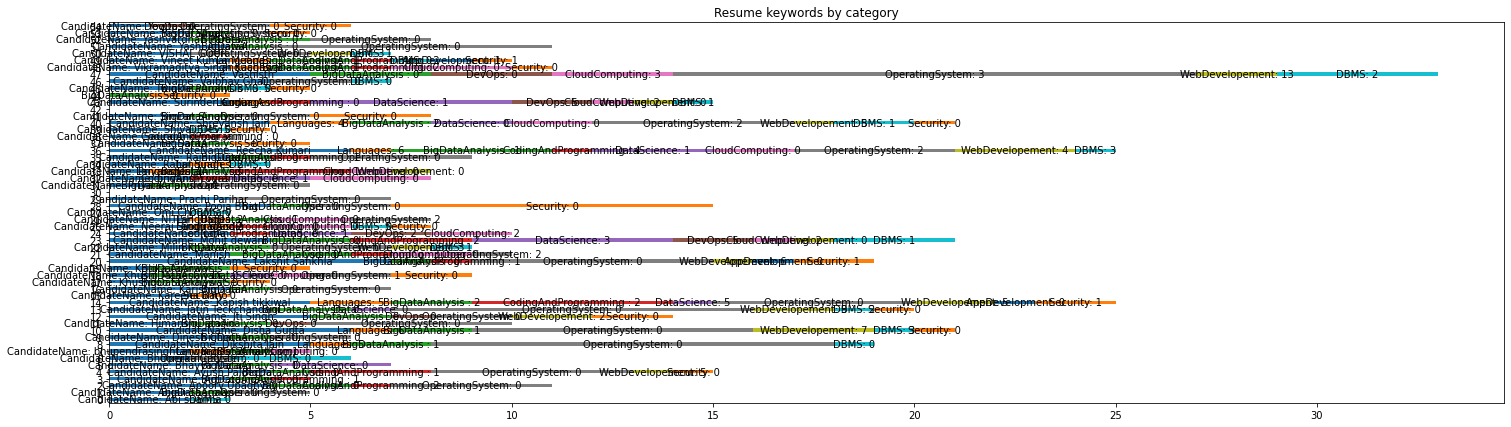

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = df.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in df.columns:
    for i in df.index:
        label = str(j)+": " + str(df.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()